In [1]:
%matplotlib widget
import matplotlib
from config.config import get_cfg_defaults
import torch
import torchvision
from torchvision.utils import make_grid
from torch.optim import AdamW
from models.unet import UNet
from models.diffusion import DenoisingDiffusionModel
from models.util import ScaleToRange, scale_to_range
from data_script.elevation_dataset import ElevationDataset
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import matplotlib.colors as colors
plt.rcParams['text.usetex'] = True

# 1. Visualization Functions

In [2]:
# utility function that visualize the sampling process via a video
def save_sampling_video(samples, path, time, example_id=0):
    # todo: we need to keep the total number of frames fixed
    def update_colorbar_limits_and_cmap(fig, surface, z):
#         cbar = fig.colorbar(surface, shrink=0.5, aspect=10)
        cbar.mappable.set_clim(vmin=np.min(z), vmax=np.max(z))
        cbar.update_normal(surface)

    def set_camera_angle(ax, elev, azim):
        ax.view_init(elev=elev, azim=azim)
    
    def elevation_map(t):
        return samples[t, example_id]
    
    def update(t):
        ax.clear()
        if t < time:
            z = elevation_map(t)
        else:
            z = elevation_map(time-1)
            
        surface = ax.plot_surface(x, y, z, cmap='terrain', linewidth=1, antialiased=False)
        azim = -np.pi + t * dtheta
        set_camera_angle(ax, elev=45, azim=np.degrees(azim))
#         update_colorbar_limits_and_cmap(fig, surface, z)
        return surface,

    T, B, C, H, W = samples.shape
    dtheta = 2 * np.pi / T
    resolution = 0.1
    x = np.arange(0, H*resolution, resolution)
    y = np.arange(0, W*resolution, resolution)
    x, y = np.meshgrid(x, y)
    last_sample = samples[-1, example_id].squeeze().to('cpu').detach().numpy()
    samples = torch.squeeze(samples, dim=2).to('cpu').detach().numpy()


    fig = plt.figure()
    ax = fig.gca(projection='3d')
    set_camera_angle(ax, elev=45, azim=-90)
    surf = ax.plot_surface(x, y, last_sample, cmap='terrain', linewidth=1, antialiased=False)
    # Add a colorbar to represent the elevation values
    cbar = fig.colorbar(surf, shrink=0.5, aspect=5)
    update_colorbar_limits_and_cmap(fig, surf, last_sample)
    # Set labels for axes
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Elevation')
    # Show the plot
    anim = FuncAnimation(fig, update, frames=np.arange(0, time+100), interval=30, blit=True)

    # Save as mp4 (requires ffmpeg)
    anim.save(path, writer='ffmpeg')
    plt.show()

# utility function that visualizes the elevation map in 3D
def visualize_elevation_map(last_samples, n_rows=2, n_cols=3, subtitles=None):
    # we choose the first six samples to show
    num_viz = 6
    vis_samples = last_samples[:num_viz].squeeze().to('cpu').detach().numpy()
    
    B, C, H, W = last_samples.shape
    resolution = 0.1
    x = np.arange(0, H*resolution, resolution)
    y = np.arange(0, W*resolution, resolution)
    x, y = np.meshgrid(x, y)
    
    fig = plt.figure(figsize=(10, 6))
    
    # Normalize the colormap
    norm = colors.Normalize(vmin=np.min(vis_samples), vmax=np.max(vis_samples))
    # Create a ScalarMappable with the desired colormap
    sm = plt.cm.ScalarMappable(cmap='terrain', norm=norm)
    sm.set_array([])  # Important: This line is required to make the colorbar work

    for i in range(n_rows):
        for j in range(n_cols):
            index = i*n_cols+j
            ax = fig.add_subplot(n_rows, n_cols, index+1, projection='3d')
            if subtitles != None:
                ax.set_title(subtitles[index])
            ax.view_init(elev=45, azim=-45)
            surf = ax.plot_surface(x, y, vis_samples[index], cmap='terrain', linewidth=1, antialiased=False)
    # Create the colorbar outside the plot
    cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
    fig.colorbar(sm, cax=cbar_ax)
    plt.subplots_adjust(left=0, top=0.95, wspace=0.1, hspace=0.1, right=0.9)
    plt.show()

# 2. Original Data Visualization

Let's first look at what the original data look like

In [3]:
dataset = ElevationDataset('data/elevation')

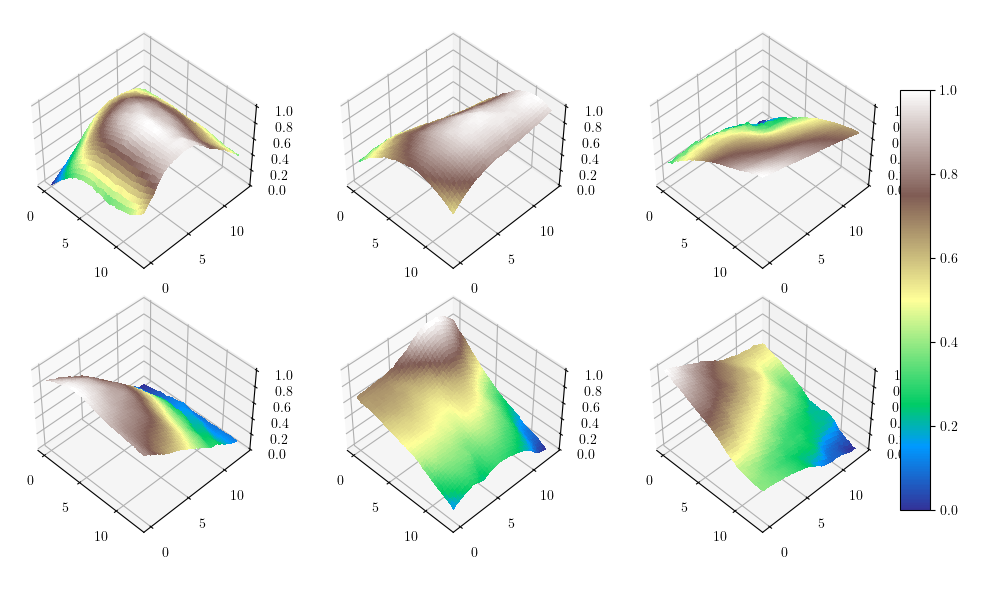

In [4]:
# randomly choose six terrain maps
indices = np.random.randint(0, len(dataset), 6)
original_terrains = []
for i in indices:
    original_terrains.append(dataset[i][0])
original_terrains = torch.stack(original_terrains, dim=0)
original_terrains = scale_to_range(original_terrains, -1, 1, 0, 1)
# visualize
visualize_elevation_map(original_terrains)

# 3. Model Loading

In [5]:
# loading the ddpm model
# cfg_file = 'config/elevation-2.yaml'
cfg_file = 'config/elevation-3.yaml'
cfg = get_cfg_defaults()
cfg.merge_from_file(cfg_file)
unet = UNet(cfg.unet.in_channels, cfg.unet.out_channels, cfg.unet.base_channel_count).to('cuda')
ddpm = DenoisingDiffusionModel(unet, 
                                total_diffusion_steps=cfg.ddpm.total_diffusion_steps, 
                                var_schedule=cfg.ddpm.var_schedule).to('cuda')
ddpm.to('cuda')
model_root_path = "/home/ubuntu/research/env-gen-diffusion/result/"
model_path = "elevation_experiment-3/models/model_500.pth"
ddpm.load_state_dict(torch.load(model_root_path + model_path))

<All keys matched successfully>

# 4. New Sample Generation from DDPM

In [6]:
# generating samples from Gaussian noises
samples = ddpm.p_sample_loop(torch.randn(50, 1, 64, 64).to('cuda'), 1000)

In [7]:
print("Sample shape", samples.shape)
example_id = 1

Sample shape torch.Size([1001, 50, 1, 64, 64])


/tmp/ipykernel_34708/260187574.py:39: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


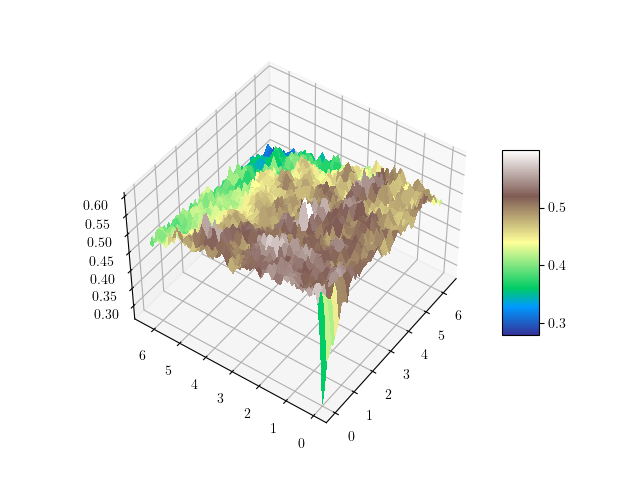

In [8]:
save_sampling_video(samples[:, example_id:example_id+1], "original.mp4", 1000)

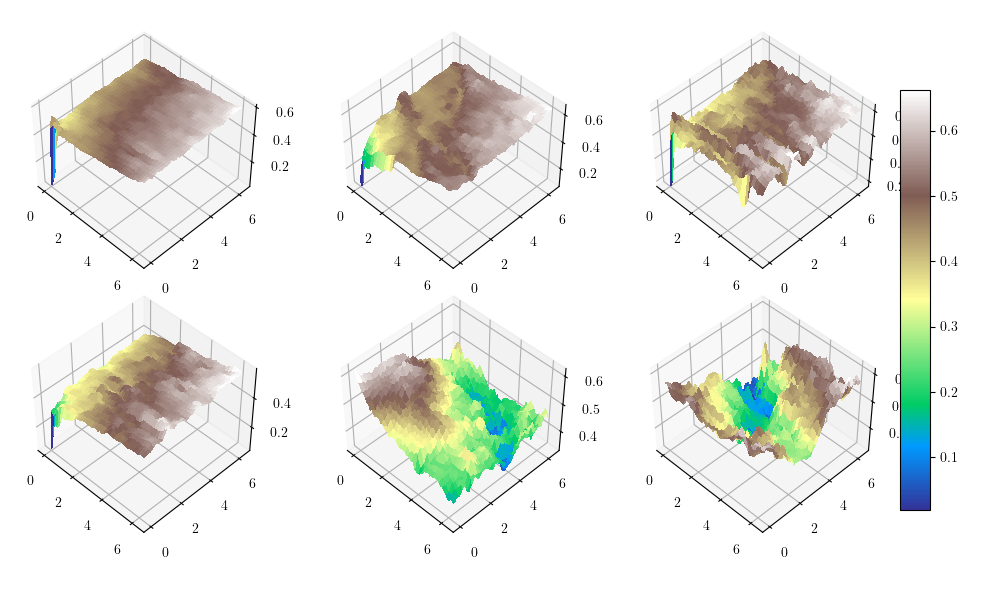

In [9]:
visualize_elevation_map(samples[-1, np.random.randint(0, samples.shape[1], 6)])

# 5. Sample Editing

There are different choices we can explore in editing the samples. 
* Editing from the denoised images: assume that we have a denoised image $\tilde{x}_0$ using the DDPM $p_\theta(x_t|x_{t-1})$, we perturb it using two different timesteps $1 < t_1 < t_2 <= 1000$ (where $1000$ is the maximum number of diffusion steps). To sample a new image we can leverage the following to stragegies:
   * use the same $t_1$ and $t_2$ with the corresponding variance schedule $\beta_{t_1}$ and $\beta_{t_2}$ for denoising.
   * use a different timestep $t'$ the $\beta_{t'}$ for denoising.
* Editing from the original images.

## 5.1 Editing from Denoised Images

This section first explores editing using a denoised image.

### 5.1.1 Preparation

In [10]:
# we randomly choose a sample from the batch
example_id = 10
last_sample = samples[-1, example_id].view(1, 1, 64, 64)

In [11]:
# choose 5 different forward steps
ts = torch.tensor([1, 100, 300, 500, 700], device=torch.device("cuda"))

### 5.1.2 Diffusion Forward Steps

In [12]:
# we add noises to the denoised sample
q_xs = []
for i in range(ts.shape[0]):
    q_x = ddpm.q_sample(last_sample, ts[i:i+1])
    q_xs.append(q_x)
q_xs.insert(0, last_sample)
q_xs = torch.stack(q_xs, dim=0).squeeze(dim=1)

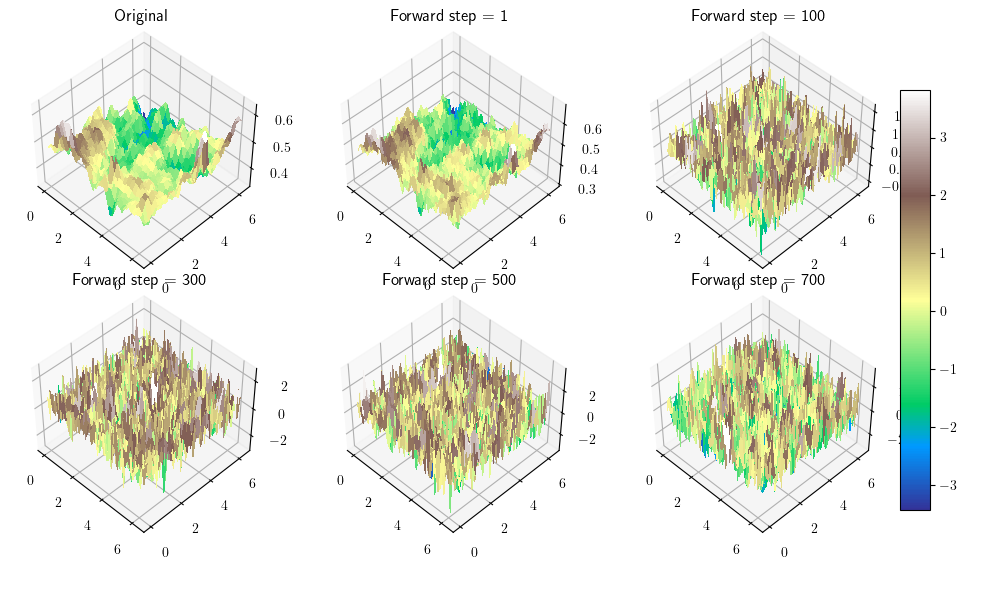

In [13]:
subtitle = [f"Forward step = {ts[i].item()}" for i in range(ts.shape[0])]
subtitle.insert(0, "Original")
visualize_elevation_map(q_xs, subtitles=subtitle)

### 5.1.3 Diffusion Reverse Process Version One: Use the Same Timesteps to Denoise

In [14]:
p_xs = []
p_xs_seq = []
for i in range(ts.shape[0]):
    p_x = ddpm.p_sample_loop(q_xs[i:i+1], ts[i])
    p_xs.append(p_x[-1])
    p_xs_seq.append(p_x)
p_xs.insert(0, last_sample)
p_xs = torch.stack(p_xs, dim=0).squeeze(dim=1)

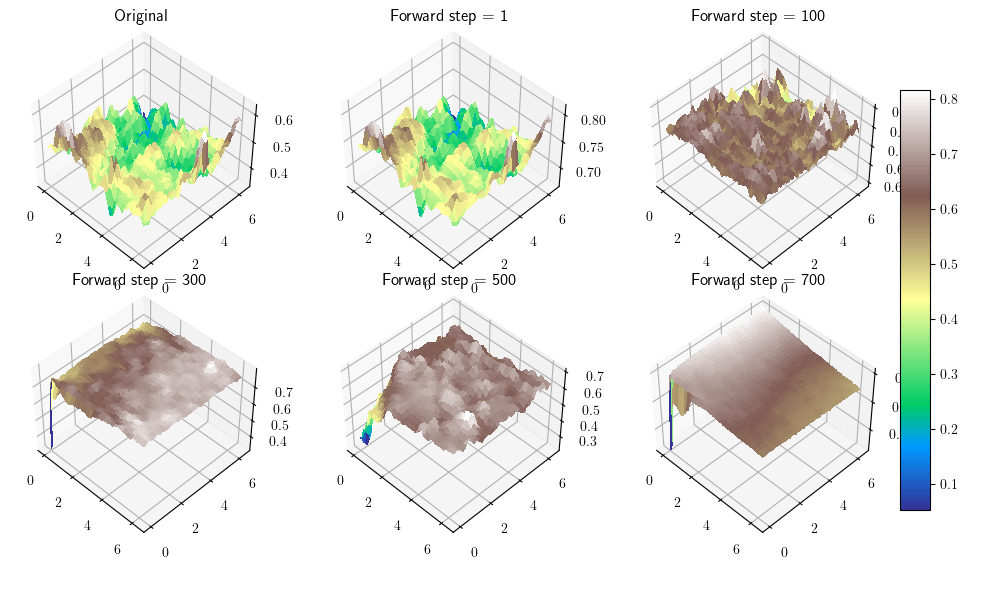

In [15]:
visualize_elevation_map(p_xs, subtitles=subtitle)

/tmp/ipykernel_34708/260187574.py:39: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


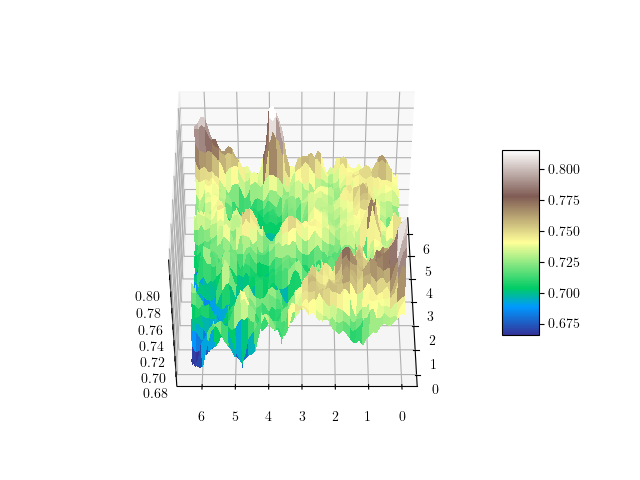

/tmp/ipykernel_34708/260187574.py:39: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


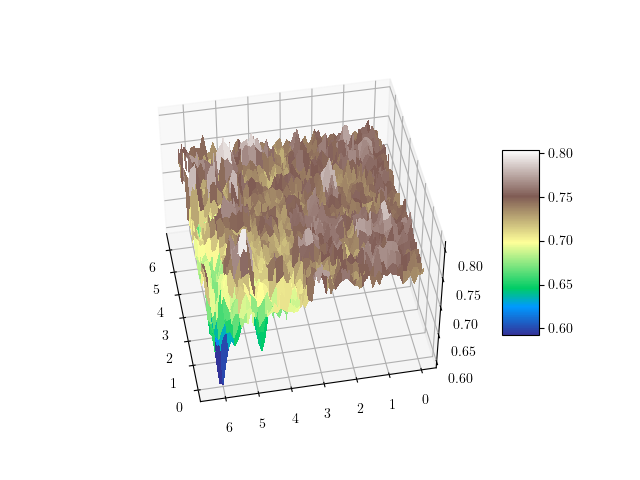

/tmp/ipykernel_34708/260187574.py:39: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


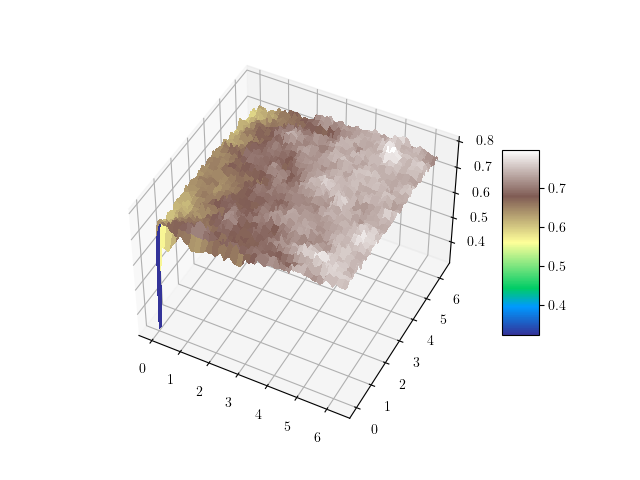

/tmp/ipykernel_34708/260187574.py:39: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


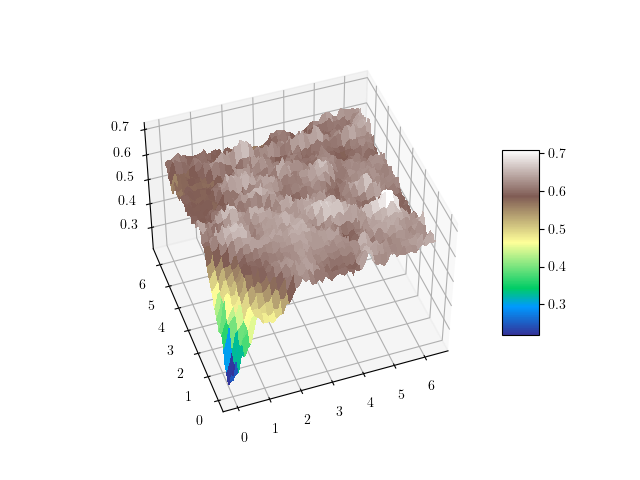

/tmp/ipykernel_34708/260187574.py:39: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


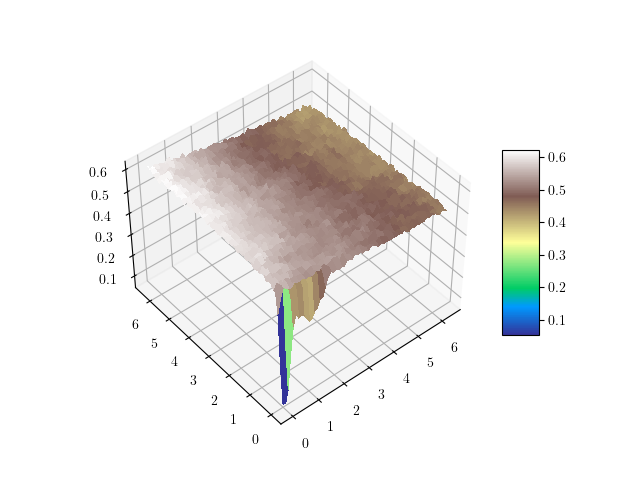

In [16]:
for i in range(ts.shape[0]):
    x_seq = p_xs_seq[i]
    save_sampling_video(x_seq, "t_{}.mp4".format(ts[i].item()), ts[i].item())